In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import (
    dynamic_feature_last_position_taken,
    dynamic_feature_real_position  # you can import it if you ever need it
)

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    nonstationary_prob_model, 
    make_ohlc,
    FeatureEngineering,
    excess_return_metric,
    extract_signals,
)
from RLTrade.plot_utils import (
    plot_candlestick_subplots,
    plot_metrics_subplots,
    build_fig,
    plot_signals_distribution,
)

In [2]:
x0, mu_epsilon = 100, 200

N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

train_set_random_state = 42
x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=train_set_random_state)
y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
# spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

In [3]:
plot_candlestick_subplots(
    data_list=[
        (x_o, x_h, x_l, x_c),
        (y_o, y_h, y_l, y_c),
        (spread_o, spread_h, spread_l, spread_c)
    ],
    titles=['X', 'Y', 'Y - X'],
    x_index=df.index,
)

0.002344410052469549 0.002539517789301022


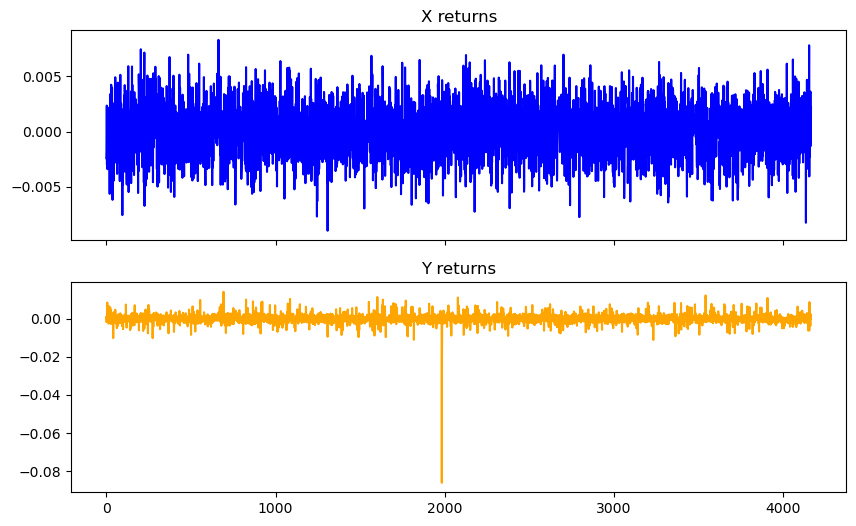

In [4]:
# plot volatility of X and Y
x_rets = np.diff(x_c) / x_c[:-1]
y_rets = np.diff(y_c) / y_c[:-1]
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(x_rets, label='X returns', color='blue')
axs[0].set_title('X returns')
axs[1].plot(y_rets, label='Y returns', color='orange')
axs[1].set_title('Y returns')

print(np.std(x_rets), np.std(y_rets))

In [5]:
# confirm the x, y pair is kind of correlated, i.e. Z_t = Y_t - beta * X_t can be fitted with a significant beta
x_ols = sm.add_constant(x_c)
ols = sm.OLS(y_c, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     769.1
Date:                Thu, 15 May 2025   Prob (F-statistic):          1.74e-155
Time:                        21:24:39   Log-Likelihood:                -15515.
No. Observations:                4166   AIC:                         3.103e+04
Df Residuals:                    4164   BIC:                         3.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        190.6289      4.053     47.038      0.0

In [6]:
# Confirm the spread (residual of Y - X) is non stationary
adfuller_test = adfuller(spread_c)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -2.33429342953823
p-value: 0.16114602605890432
Is the spread stationary? No


### Demo: Using Deep Q-Learning on the spread (with feature engineering of moving window mean correction)

In [7]:
feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 5,  # sidetrack: the rolling window mean correction can somehow help detect mean shift
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)
df_train

,open,high,low,close,feature_close_rolling_mean_corrected
2020-01-01,199.986174,200.368261,199.518702,200.096006,0.000000
2020-01-02,200.021893,200.600828,199.803777,200.562116,0.233055
2020-01-03,200.455557,200.636141,199.833097,200.187135,-0.094617
2020-01-04,200.016937,200.666950,199.510719,200.318260,0.027381
2020-01-05,200.238011,200.827957,199.810026,200.527162,0.189026
...,...,...,...,...,...
2031-05-24,214.906470,214.906470,213.236840,213.302451,-1.065724
2031-05-25,213.301824,214.226358,212.668037,213.593410,-0.580671
2031-05-26,213.586992,214.439227,213.066514,214.198620,0.114249
2031-05-27,214.174888,214.744832,214.029234,214.283742,0.229912


In [8]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_prob_model",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1.]
Market Return :  7.31%   |   Portfolio Return : -30.48%   |   Excess Return : -44.9%   |   Position Changes : 2745   |   Episode Length : 4166   |   


In [9]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions, target_net_layers=[8], policy_net_layers=[8])
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  7.31%   |   Portfolio Return : -9.07%   |   Excess Return : -17.47%   |   Position Changes : 2923   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : -58.49%   |   Excess Return : -95.71%   |   Position Changes : 3545   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : -53.59%   |   Excess Return : -84.48%   |   Position Changes : 3730   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : -7.48%   |   Excess Return : -16.27%   |   Position Changes : 2456   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : -11.18%   |   Excess Return : -19.21%   |   Position Changes : 1399   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : 10.34%   |   Excess Return : 2.37%   |   Position Changes : 1392   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : 18.77%   |   Excess Return : 8.78%   |   Position C

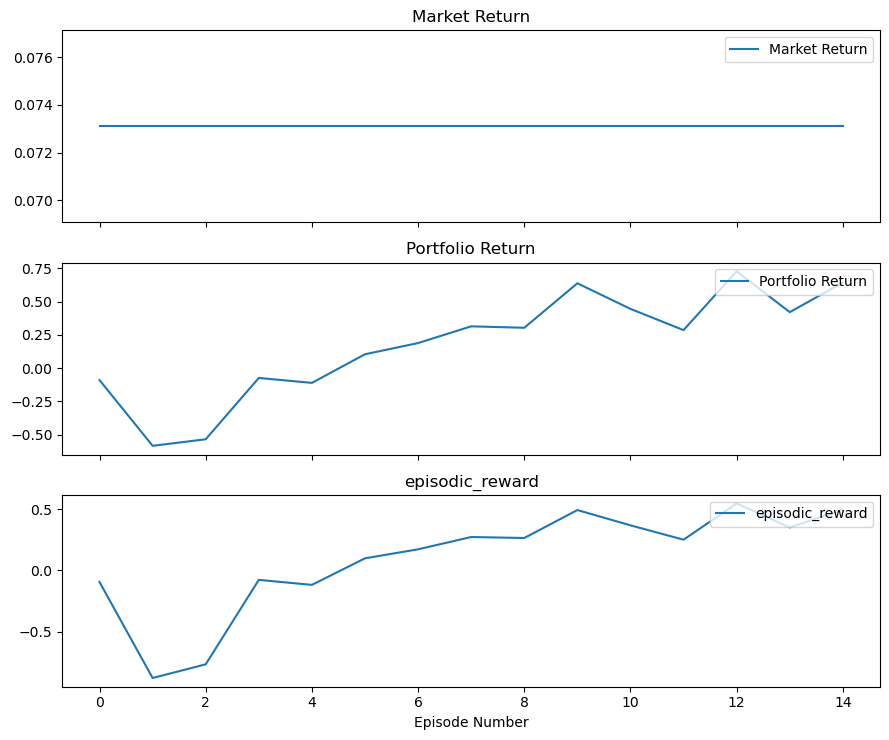

In [10]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

plot_metrics_subplots(all_metrics, ["Market Return", "Portfolio Return", "episodic_reward"])

In [11]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_prob_model_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -4.51%   |   Portfolio Return : 14.78%   |   Excess Return : 17.21%   |   Position Changes : 900   |   Episode Length : 4166   |   
Market Return : -10.55%   |   Portfolio Return : 31.42%   |   Excess Return : 37.18%   |   Position Changes : 884   |   Episode Length : 4166   |   
Market Return : -13.03%   |   Portfolio Return : 12.27%   |   Excess Return : 24.24%   |   Position Changes : 924   |   Episode Length : 4166   |   
Market Return : -14.90%   |   Portfolio Return : 18.85%   |   Excess Return : 30.34%   |   Position Changes : 918   |   Episode Length : 4166   |   
Market Return : -0.59%   |   Portfolio Return : 25.42%   |   Excess Return : 22.3%   |   Position Changes : 960   |   Episode Length : 4166   |   
Market Return : 25.96%   |   Portfolio Return : 28.07%   |   Excess Return : 0.62%   |   Position Changes : 923   |   Episode Length : 4166   |   
Market Return :  3.77%   |   Portfolio Return : 34.41%   |   Excess Return : 24.46%   |   Position Changes : 96

In [12]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

historical_info_df = history_dfs[-2]
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_low', 'data_high', 'data_close', 'data_volume', 'data_open',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [13]:
buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()

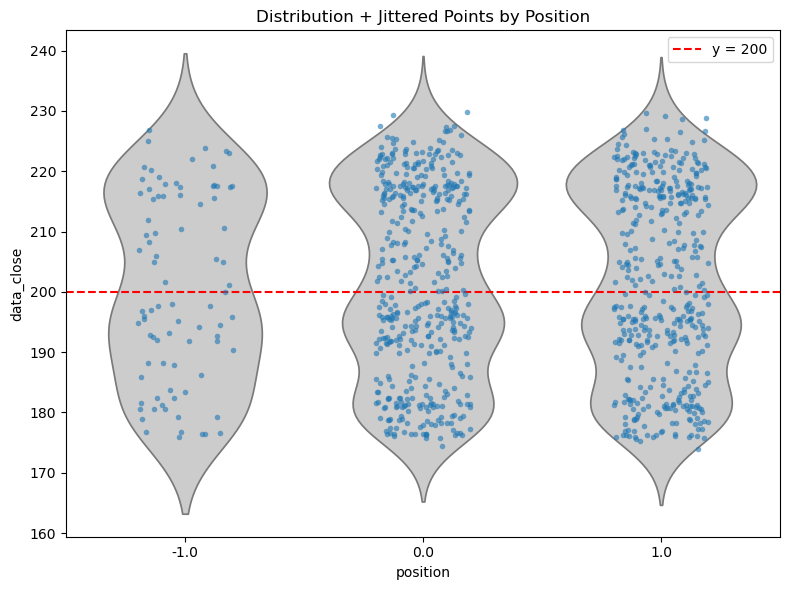

In [14]:
signals_df_qlearning = pd.concat([buy_df_qlearning, sell_df_qlearning, exit_df_qlearning])
plot_signals_distribution(signals_df_qlearning, threshold=mu_epsilon)

### Demo: Using XGBoost model-based Q-Learning on the spread (with same feature engineering as NN)

In [15]:
# build features
df_train = df.copy()

feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 5,  # sidetrack: the rolling window mean correction can somehow help detect mean shift
       'mode': 'diff',
     }},
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,open,high,low,close,feature_close_rolling_mean_corrected
2020-01-01,199.986174,200.368261,199.518702,200.096006,0.000000
2020-01-02,200.021893,200.600828,199.803777,200.562116,0.233055
2020-01-03,200.455557,200.636141,199.833097,200.187135,-0.405357
2020-01-04,200.016937,200.666950,199.510719,200.318260,0.075561
2020-01-05,200.238011,200.827957,199.810026,200.527162,0.122671
...,...,...,...,...,...
2031-05-24,214.906470,214.906470,213.236840,213.302451,-1.381995
2031-05-25,213.301824,214.226358,212.668037,213.593410,0.485053
2031-05-26,213.586992,214.439227,213.066514,214.198620,0.694920
2031-05-27,214.174888,214.744832,214.029234,214.283742,0.115662


In [16]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_prob_model",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 1.]
Market Return :  7.31%   |   Portfolio Return : -7.33%   |   Excess Return : -14.74%   |   Position Changes : 1   |   Episode Length : 4166   |   


In [17]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  7.31%   |   Portfolio Return : -13.96%   |   Excess Return : -22.87%   |   Position Changes : 2752   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : -37.70%   |   Excess Return : -54.9%   |   Position Changes : 2788   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return :  1.31%   |   Excess Return : -7.4%   |   Position Changes : 2813   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : -26.00%   |   Excess Return : -37.99%   |   Position Changes : 2789   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : 114.98%   |   Excess Return : 68.73%   |   Position Changes : 2893   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : 27.91%   |   Excess Return : 16.79%   |   Position Changes : 2877   |   Episode Length : 4166   |   
Market Return :  7.31%   |   Portfolio Return : 141.02%   |   Excess Return : 80.23%   |   Position C

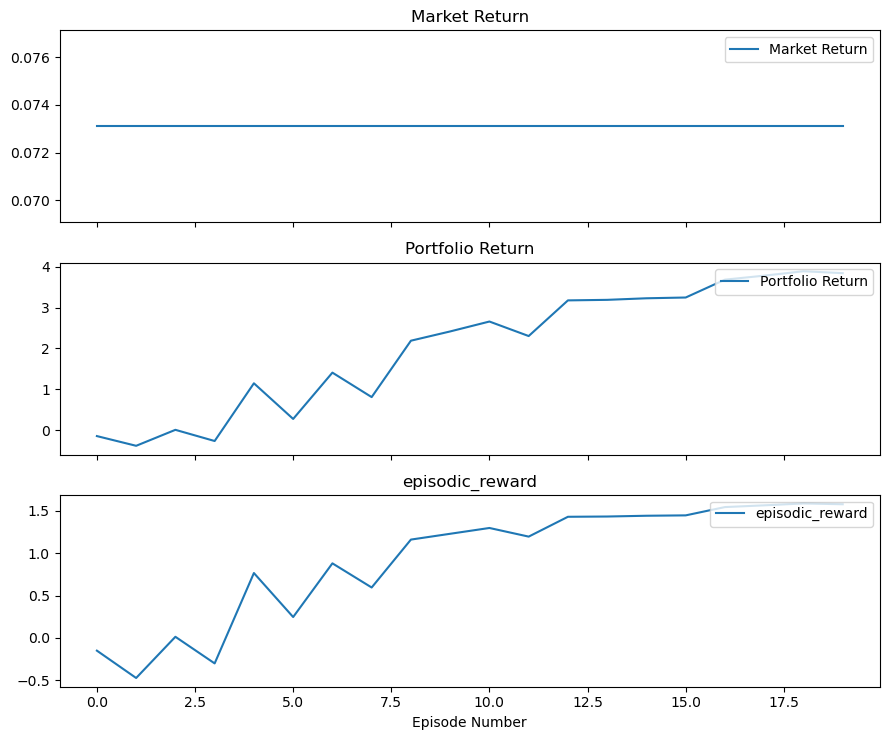

In [18]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

plot_metrics_subplots(all_metrics, ["Market Return", "Portfolio Return", "episodic_reward"])

In [ ]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_prob_model_xgboost",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -4.51%   |   Portfolio Return : 33.95%   |   Excess Return : 33.38%   |   Position Changes : 2810   |   Episode Length : 4166   |   
Market Return : -10.55%   |   Portfolio Return : 25.19%   |   Excess Return : 33.23%   |   Position Changes : 2797   |   Episode Length : 4166   |   
Market Return : -13.03%   |   Portfolio Return : 71.34%   |   Excess Return : 67.42%   |   Position Changes : 2796   |   Episode Length : 4166   |   
Market Return : -14.90%   |   Portfolio Return : 111.28%   |   Excess Return : 89.88%   |   Position Changes : 2756   |   Episode Length : 4166   |   
Market Return : -0.59%   |   Portfolio Return : 22.00%   |   Excess Return : 20.13%   |   Position Changes : 2804   |   Episode Length : 4166   |   
Market Return : 25.96%   |   Portfolio Return :  8.23%   |   Excess Return : -15.47%   |   Position Changes : 2760   |   Episode Length : 4166   |   
Market Return :  3.77%   |   Portfolio Return :  0.08%   |   Excess Return : -4.15%   |   Position Ch

In [20]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

historical_info_df = history_dfs[-1]
buy_df_xgb, sell_df_xgb, exit_df_xgb = extract_signals(historical_info_df)
fig_xgb = build_fig(
    historical_info_df,
    buy_df_xgb,
    sell_df_xgb,
    exit_df_xgb
)
fig_xgb.show()

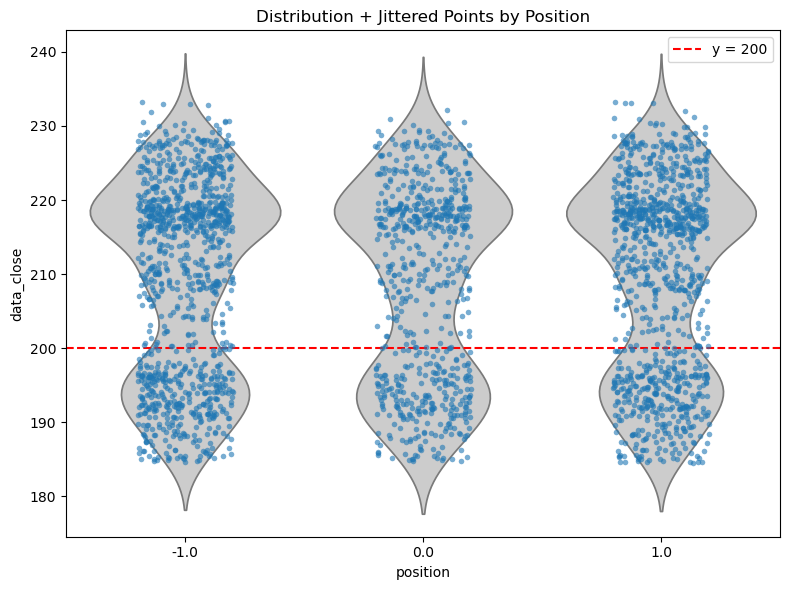

In [21]:
signals_df_xgb = pd.concat([buy_df_xgb, sell_df_xgb, exit_df_xgb])
plot_signals_distribution(signals_df_xgb, threshold=mu_epsilon)

In [22]:
len(signals_df_qlearning), len(signals_df_xgb)

(966, 2815)

In [23]:
signals_df_qlearning["above"] = signals_df_qlearning["data_close"] > mu_epsilon
signals_df_qlearning.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,43,41
0.0,220,223
1.0,219,220


In [24]:
signals_df_xgb["above"] = signals_df_xgb["data_close"] > mu_epsilon
signals_df_xgb.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,357,733
0.0,241,443
1.0,340,701
